In [ ]:
from collections import Counter, defaultdict
from itertools import combinations
import pandas as pd
import numpy as np
import operator
import math
import itertools
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing, tree
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid

# Loading Datasets & Preprocessing

In [ ]:
def preprocess(df, value):
    ## only want years 2011-2012
    required_columns = ['Province'] + [str(year) for year in range(2011, 2022) if str(year) in df.columns]
    filtered_df = df[required_columns]

    ## make it 1 row = 1 province at 1 year instead of 1 province
    melted_df = pd.melt(filtered_df, id_vars='Province', var_name='Year', value_name=value)

    ## making the datatype easy to work with
    # year object to datetime
    melted_df['Year'] = pd.to_datetime(melted_df['Year'], format='%Y')
    # some rows have - as a value which cannot be converted to float, so turn to nan first
    melted_df[value] = pd.to_numeric(melted_df[value].replace('-', pd.NA), errors='coerce')

    return melted_df

## target datasets

In [ ]:
# be mindful that this dataset does not have 2016 year
energy_consumption = pd.read_csv("/work/Energy Consumption.csv")
energy_consumption = preprocess(energy_consumption, 'energy_consumption')
energy_consumption

,Province,Year,energy_consumption
0,ACEH,2011-01-01,1579.77
1,SUMATERA UTARA,2011-01-01,7194.03
2,SUMATERA BARAT,2011-01-01,2403.10
3,RIAU,2011-01-01,2361.15
4,JAMBI,2011-01-01,1054.17
...,...,...,...
345,MALUKU,2021-01-01,582.88
346,MALUKU UTARA,2021-01-01,637.04
347,PAPUA BARAT,2021-01-01,583.21
348,PAPUA,2021-01-01,1237.64


In [ ]:
energy_generation = pd.read_csv("/work/Energy Generation.csv")
energy_generation = preprocess(energy_generation, 'energy_generation')
energy_generation

,Province,Year,energy_generation
0,ACEH,2011-01-01,1579.77
1,SUMATERA UTARA,2011-01-01,7194.03
2,SUMATERA BARAT,2011-01-01,2403.10
3,RIAU,2011-01-01,2361.15
4,JAMBI,2011-01-01,1054.17
...,...,...,...
345,MALUKU,2021-01-01,969.89
346,MALUKU UTARA,2021-01-01,377.04
347,PAPUA BARAT,2021-01-01,677.34
348,PAPUA,2021-01-01,1360.61


In [ ]:
energy_capacity = pd.read_csv("/work/Energy Capacity.csv")
energy_capacity = preprocess(energy_capacity, 'energy_capacity')
energy_capacity

,Province,Year,energy_capacity
0,ACEH,2011-01-01,159.26
1,SUMATERA UTARA,2011-01-01,2450.67
2,SUMATERA BARAT,2011-01-01,33.45
3,RIAU,2011-01-01,111.23
4,JAMBI,2011-01-01,12.82
...,...,...,...
345,MALUKU,2021-01-01,390.74
346,MALUKU UTARA,2021-01-01,157.88
347,PAPUA BARAT,2021-01-01,267.51
348,PAPUA,2021-01-01,525.64


## features

### socioeconomic

In [ ]:
homeowners = pd.read_csv("/work/Homeowners.csv")
homeowners.drop([35,36,37,38], inplace=True) # delete subtext
homeowners = preprocess(homeowners, 'prop_homeowners')
homeowners

,Province,Year,prop_homeowners
0,ACEH,2011-01-01,79.02
1,SUMATERA UTARA,2011-01-01,66.07
2,SUMATERA BARAT,2011-01-01,69.51
3,RIAU,2011-01-01,68.42
4,JAMBI,2011-01-01,78.02
...,...,...,...
380,MALUKU,2021-01-01,75.13
381,MALUKU UTARA,2021-01-01,83.40
382,PAPUA BARAT,2021-01-01,76.03
383,PAPUA,2021-01-01,83.20


In [ ]:
household_work = pd.read_csv("/work/Household working.csv")
household_work = household_work.rename(columns={'Unnamed: 0': 'Province'})
household_work = preprocess(household_work, 'prop_working')
household_work

,Province,Year,prop_working
0,Aceh,2011-01-01,87.13
1,Sumatera Utara,2011-01-01,90.28
2,Sumatera Barat,2011-01-01,86.66
3,R i a u,2011-01-01,91.90
4,J a m b i,2011-01-01,90.87
...,...,...,...
380,Maluku,2021-01-01,86.18
381,Maluku Utara,2021-01-01,89.85
382,Papua Barat,2021-01-01,91.64
383,P a p u a,2021-01-01,94.32


In [ ]:
school_inattend = pd.read_csv("/work/School Inattendance.csv")
school_inattend = preprocess(school_inattend, 'prop_school_absentees')
school_inattend

,Province,Year,prop_school_absentees
0,Aceh,2011-01-01,3.17
1,Sumatera Utara,2011-01-01,2.34
2,Sumatera Barat,2011-01-01,2.02
3,Riau,2011-01-01,2.39
4,Jambi,2011-01-01,3.56
...,...,...,...
380,Maluku,2021-01-01,2.27
381,Maluku Utara,2021-01-01,1.08
382,Papua Barat,2021-01-01,3.55
383,Papua,2021-01-01,25.55


In [ ]:
toilet_access = pd.read_csv("/work/Toilet Facility Access.csv")
toilet_access.drop([35,36,37,38,39], inplace=True) # delete subtext
toilet_access = preprocess(toilet_access, 'prop_toilet_access')
toilet_access

,Province,Year,prop_toilet_access
0,Aceh,2011-01-01,60.34
1,Sumatera Utara,2011-01-01,74.88
2,Sumatera Barat,2011-01-01,54.65
3,Riau,2011-01-01,83.81
4,Jambi,2011-01-01,68.12
...,...,...,...
380,Maluku,2021-01-01,72.87
381,Maluku Utara,2021-01-01,69.73
382,Papua Barat,2021-01-01,75.48
383,Papua,2021-01-01,63.34


### economic

In [ ]:
gdp = pd.read_csv("/work/GDP.csv")
# gdp represented with columns
gdp = gdp.replace(',', '', regex=True)
# then preprocess
gdp = preprocess(gdp, 'gdp')
gdp

,Province,Year,gdp
0,Aceh,2011-01-01,108217.63
1,North Sumatra,2011-01-01,377037.10
2,West Sumatra,2011-01-01,118674.29
3,Riau,2011-01-01,485649.34
4,Jambi,2011-01-01,103522.91
...,...,...,...
380,Maluku,2021-01-01,48564.22
381,North Maluku,2021-01-01,52359.85
382,West Papua,2021-01-01,85072.86
383,Papua,2021-01-01,235343.25


In [ ]:
population = pd.read_csv("/work/Population.csv")
population.drop([35,36,37,38], inplace=True) # delete subtext
population = preprocess(population, 'population')
population

,Province,Year,population
0,Aceh,2012-01-01,4715.0
1,Sumatera Utara,2012-01-01,13408.0
2,Sumatera Barat,2012-01-01,5000.0
3,Riau,2012-01-01,5879.0
4,Kep. Riau,2012-01-01,3227.0
...,...,...,...
345,Maluku,2021-01-01,1862.6
346,Maluku Utara,2021-01-01,1299.2
347,Papua Barat,2021-01-01,1156.8
348,Papua,2021-01-01,4355.5


In [ ]:
health_complaints = pd.read_csv("/work/Health Complaints.csv")
health_complaints.drop([23], inplace=True) #dropped nul values
health_complaints.drop(list(health_complaints.filter(regex = 'boy')), axis = 1, inplace = True)
health_complaints.drop(list(health_complaints.filter(regex = 'girl')), axis = 1, inplace = True)
health_complaints
health_complaints = preprocess(health_complaints, 'health_complaints')
health_complaints

,Province,Year,health_complaints
0,Aceh,2011-01-01,30.62
1,Sumatera Utara,2011-01-01,25.44
2,Sumatera Barat,2011-01-01,29.30
3,Riau,2011-01-01,24.84
4,Jambi,2011-01-01,22.79
...,...,...,...
369,Maluku,2021-01-01,16.44
370,Maluku Utara,2021-01-01,15.68
371,Papua Barat,2021-01-01,20.77
372,Papua,2021-01-01,12.76


### physical / climate

In [ ]:
# note! missing 2011
land_area = pd.read_csv("/work/Land Area.csv")
# Loop through specified columns, remove spaces
columns_to_convert = [str(year) for year in range(2012, 2022)]
for column_name in columns_to_convert:
    land_area[column_name] = land_area[column_name].str.replace(' ', '')

land_area = preprocess(land_area, 'land_area')
land_area

,Province,Year,land_area
0,Aceh,2012-01-01,57956.00
1,Sumatera Utara,2012-01-01,72981.23
2,Sumatera Barat,2012-01-01,42012.89
3,Riau,2012-01-01,87023.66
4,Kepulauan Riau,2012-01-01,8201.72
...,...,...,...
345,Maluku,2021-01-01,46914.03
346,Maluku Utara,2021-01-01,31982.50
347,Papua,2021-01-01,319036.05
348,Papua Barat,2021-01-01,99671.63


In [ ]:
# note! missing 2016, 2017, 2018, 2019, 2020, 2021
rainy_days = pd.read_csv("/work/Rainy Days.csv")
rainy_days = preprocess(rainy_days, 'num_rainy_days')
rainy_days

,Province,Year,num_rainy_days
0,Aceh,2011-01-01,150.0
1,Sumatera Utara,2011-01-01,225.0
2,Sumatera Barat,2011-01-01,NaN
3,Riau,2011-01-01,211.0
4,Jambi,2011-01-01,209.0
...,...,...,...
165,Sulawesi Barat,2015-01-01,93.0
166,Maluku,2015-01-01,167.0
167,Maluku Utara,2015-01-01,127.0
168,Papua Barat,2015-01-01,218.0


# Combine to create final dataframe

In [ ]:
dfs_list = [energy_generation, energy_capacity, homeowners, household_work, school_inattend, toilet_access,gdp, population, land_area, rainy_days, health_complaints]  # Add all your datasets here
combined_df = pd.concat(dfs_list, axis=1)
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
list(combined_df.columns)

['Province',
 'Year',
 'energy_generation',
 'energy_capacity',
 'prop_homeowners',
 'prop_working',
 'prop_school_absentees',
 'prop_toilet_access',
 'gdp',
 'population',
 'land_area',
 'num_rainy_days',
 'health_complaints']

note! all target datasets are missing year 2016 so energy_consumption, energy_generation, energy_capacity in that year are nans (we have 35 nan values for all target variables) -- this is also shown in how even if all datasets go through the same preprocessing function, these 3 datasets have 350 rows and all other datasets have 385 rows

# Feature Selection

## Correlation Coefficient Heat Map 

### Target Var  = Energy Generation

In [ ]:
engen = combined_df.drop(["Year"], axis = 1)

In [ ]:
gen_matrix = engen.corr()
round(gen_matrix,2)

,energy_generation,energy_capacity,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area,num_rainy_days,health_complaints
energy_generation,1.00,0.98,-0.01,-0.20,-0.02,0.12,0.98,0.96,0.90,-0.14,0.03
energy_capacity,0.98,1.00,0.04,-0.19,-0.01,0.11,0.97,0.96,0.91,-0.17,0.03
prop_homeowners,-0.01,0.04,1.00,0.21,0.26,-0.27,-0.05,0.03,-0.00,-0.11,-0.05
prop_working,-0.20,-0.19,0.21,1.00,0.29,-0.27,-0.18,-0.17,-0.01,0.18,-0.05
prop_school_absentees,-0.02,-0.01,0.26,0.29,1.00,-0.38,-0.02,-0.00,0.02,-0.10,0.05
prop_toilet_access,0.12,0.11,-0.27,-0.27,-0.38,1.00,0.14,0.08,0.03,-0.17,0.08
gdp,0.98,0.97,-0.05,-0.18,-0.02,0.14,1.00,0.96,0.92,-0.13,0.02
population,0.96,0.96,0.03,-0.17,-0.00,0.08,0.96,1.00,0.94,-0.13,0.02
land_area,0.90,0.91,-0.00,-0.01,0.02,0.03,0.92,0.94,1.00,-0.05,-0.05
num_rainy_days,-0.14,-0.17,-0.11,0.18,-0.10,-0.17,-0.13,-0.13,-0.05,1.00,-0.40


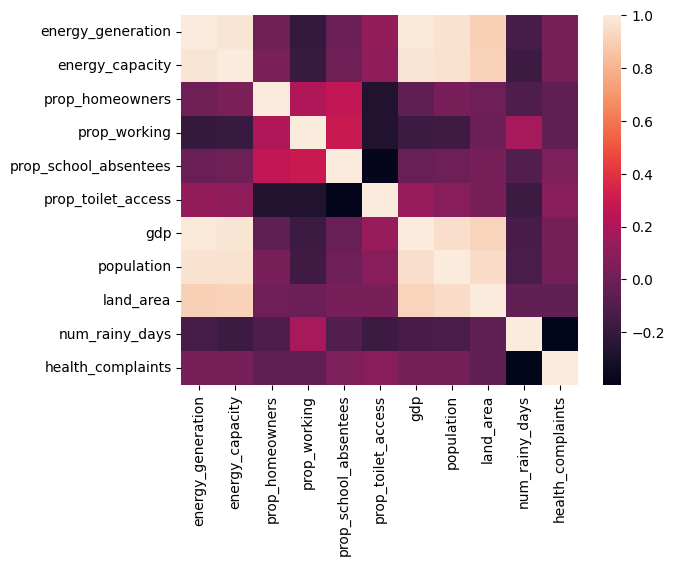

In [ ]:
sns.heatmap(gen_matrix);


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9a2d3571-826e-4759-814d-0768207fd99f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>